In [275]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import plotly.express as px
import cufflinks as cf

In [276]:
con = sqlite3.connect('amin.db')
df = pd.read_sql("select * from sales", con)
collections = pd.read_csv("collections.csv")
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:,.0f}'.format)

### Data Cleaning

In [277]:
df.isnull().sum()

user_pseudo_id             0
event_date                 0
new_event_timestamp        0
city                       6
pincode                    0
subtotal                  26
item_name_0                0
item_name_1            22819
item_name_2            28258
item_name_3            29556
item_name_4            29924
quantity_0                49
quantity_1             22819
quantity_2             28254
quantity_3             29556
quantity_4             29924
item_variant_0           583
item_variant_1         22972
item_variant_2         28306
item_variant_3         29573
item_variant_4         29928
price_0                    6
price_1                22824
price_2                28262
price_3                29556
price_4                29923
source_name              146
source_medium             84
source_origin             86
rw                         0
dtype: int64

In [278]:
df["cleaned_city"] = df["city"].str.lower().str.strip()
df["cleaned_city"] = df["cleaned_city"].apply(lambda x: "bangalore" if pd.notna(x) and x.startswith("ben") else x)
df["cleaned_city"] = df["cleaned_city"].apply(lambda x: "bangalore" if pd.notna(x) and x.startswith("ban") else x)
df["cleaned_city"] = df["cleaned_city"].apply(lambda x: "bangalore" if pd.notna(x) and x.endswith(("lore", "luru")) else x)
df["cleaned_city"] = df["cleaned_city"].fillna("bangalore")
df["subtotal"] = df["subtotal"].fillna(df["subtotal"].mean())
df.drop(columns = ["city"], inplace = True)
df["event_date"] = pd.to_datetime(df["event_date"])

In [279]:
colums = ["item_name_0",                
"item_name_1",            
"item_name_2",            
"item_name_3",            
"item_name_4",           
"quantity_0",                
"quantity_1",             
"quantity_2",             
"quantity_3",
"quantity_4",            
"item_variant_0",          
"item_variant_1",         
"item_variant_2",         
"item_variant_3",         
"item_variant_4",         
"price_0",                    
"price_1",                
"price_2",                
"price_3",                
"price_4",                ]
for i in colums:
    df[i] = df[i].replace(["None", None, "NaN"], 0).fillna(0)

In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30075 entries, 0 to 30074
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_pseudo_id       30075 non-null  object        
 1   event_date           30075 non-null  datetime64[ns]
 2   new_event_timestamp  30075 non-null  object        
 3   pincode              30075 non-null  int64         
 4   subtotal             30075 non-null  float64       
 5   item_name_0          30075 non-null  object        
 6   item_name_1          30075 non-null  object        
 7   item_name_2          30075 non-null  object        
 8   item_name_3          30075 non-null  object        
 9   item_name_4          30075 non-null  object        
 10  quantity_0           30075 non-null  float64       
 11  quantity_1           30075 non-null  float64       
 12  quantity_2           30075 non-null  float64       
 13  quantity_3           30075 non-

### Question and Answer

### Which Pincode Generates the Highest Sales ?

In [281]:
pin = df.groupby("pincode")["subtotal"].sum().reset_index().sort_values(by = "subtotal", ascending = False).nlargest(10, "subtotal")
pin["pincode"] = pin["pincode"].astype(str)
fig = px.bar(pin, x = "pincode", y = "subtotal", text = round(pin["subtotal"]/1000), labels = {"pincode":"Pincode", "subtotal": "Total Sales"},color = "subtotal", color_continuous_scale="GnBu")
fig.update_traces(
    marker_line_color = "black",
    marker_line_width = 1.5,
    texttemplate = "%{text}k",
    textposition = "outside"
)
fig.update_layout(
    height= 500,
    width = 800,
    annotations=[
        dict(
            text="Highest Sales By Pincode",
            x=0.5,
            y=1.17,
            xref="paper",
            yref="paper",
            font=dict(size=25, family="Arial", color="#C4AB41",weight = "bold"),
            showarrow=False,
            bgcolor="white",
            bordercolor="#91770A", 
            borderwidth=2,
            borderpad=14,
            width = 570,
            align = "left",
            
        )]
)
fig.show()


### Average Order value at different location

In [282]:
count_city = df["cleaned_city"].value_counts()[df["cleaned_city"].value_counts() > 9].index
newcity = df[df["cleaned_city"].isin(count_city)]
nc = newcity.groupby("cleaned_city")["subtotal"].mean().reset_index().sort_values(by = "subtotal", ascending = False)
fig = px.bar(nc, x="cleaned_city", y="subtotal",text = nc["subtotal"]/1000, labels = {"cleaned_city":"City","subtotal":"Average Order Value"}, color = "subtotal", color_continuous_scale= "Blues")
fig.update_traces(
    marker_line_color = "black",
    marker_line_width = 2,
    texttemplate = "%{text:.2f}k",
    textposition = "outside"
)
fig.update_layout(
    height= 500,
    width = 900,
    annotations=[
        dict(
            text="Average Order Value",
            x=0.5,
            y=1.17,
            xref="paper",
            yref="paper",
            font=dict(size=25, family="Arial", color="#C4AB41",weight = "bold"),
            showarrow=False,
            bgcolor="white",
            bordercolor="#91770A", 
            borderwidth=2,
            borderpad=14,
            width = 600,
            align = "left",
            
        )])
fig.show()

### What’s the trend in total orders and revenue over time (daily/weekly/monthly)?


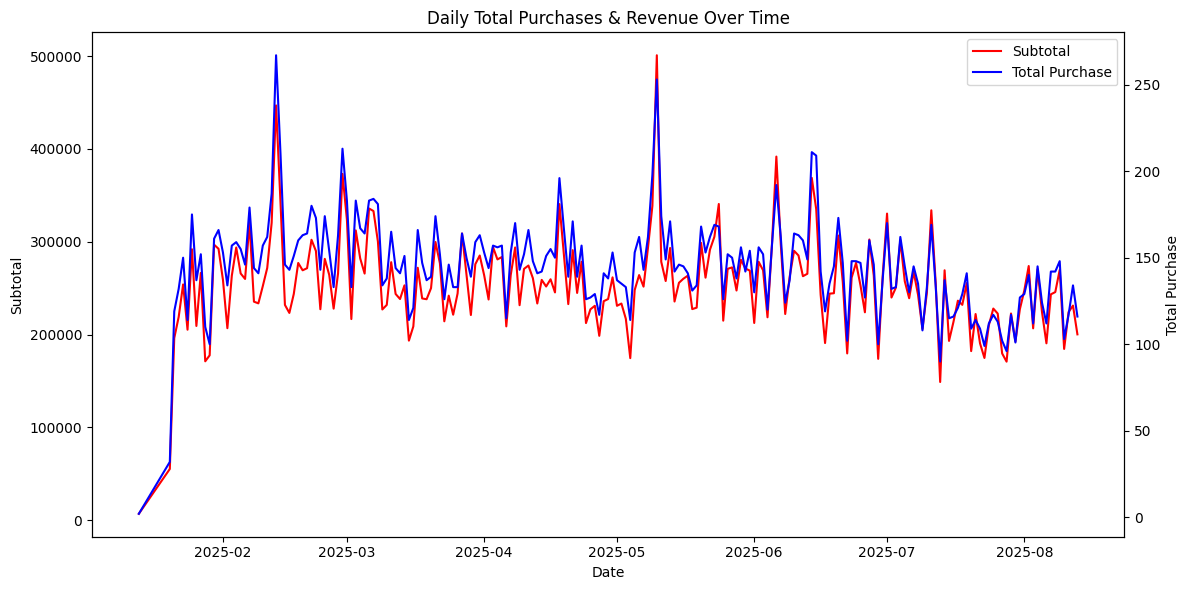

In [283]:
trends = df.groupby(df["event_date"].dt.date).agg({
    "user_pseudo_id": 'count',
    "subtotal": 'sum'
}).rename(columns = {"user_pseudo_id":"total_purchase"}).reset_index()

fig, ax1 = plt.subplots(figsize=(12, 6))
#first axis
ax1.plot(trends["event_date"], trends["subtotal"], color = "red", label = "Subtotal")
ax1.set_xlabel("Date")
ax1.set_ylabel("Subtotal")

ax2 = ax1.twinx()
ax2.plot(trends["event_date"], trends["total_purchase"], color = "blue", label = "Total Purchase")
ax2.set_ylabel("Total Purchase")
plt.title('Daily Total Purchases & Revenue Over Time')
lines1, labels1 = ax1.get_legend_handles_labels() 
lines2, labels2 = ax2.get_legend_handles_labels() 
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
plt.tight_layout()
plt.show()

### Top seller product by Revenue and Quantity

In [284]:
id_vars = [
    "user_pseudo_id", "event_date", "new_event_timestamp", "pincode",
    "subtotal", "source_name", "source_medium", "source_origin",
    "rw", "cleaned_city"
]
item_name = df.melt(
    id_vars = id_vars,
    value_vars = ["item_name_0","item_name_1","item_name_2","item_name_3","item_name_4"],
    value_name = "Product_name",
    var_name = "in"
)
item_price = df.melt(
    id_vars= id_vars,
    value_vars = ["price_0","price_1","price_2","price_3","price_4"],
    value_name = "Price",
    var_name = "ip"
)
item_quantity = df.melt(
    id_vars = id_vars,
    value_vars = ["quantity_0","quantity_1","quantity_2","quantity_3","quantity_4"],
    value_name = "Quantity",
    var_name = "iq"

)
item_variant = df.melt(
    id_vars = id_vars,
    value_vars = ["item_variant_0","item_variant_1","item_variant_2","item_variant_3","item_variant_4"],
    value_name = "Item_variant",
    var_name = "iv"

)

item_name["product_no"]    = item_name["in"].str.extract("(\d+)")
item_price["product_no"]   = item_price["ip"].str.extract("(\d+)")
item_quantity["product_no"]= item_quantity["iq"].str.extract("(\d+)")
item_variant["product_no"] = item_variant["iv"].str.extract("(\d+)")


item_name    = item_name.drop(columns=["in"])
item_price   = item_price.drop(columns=["ip"])
item_quantity= item_quantity.drop(columns=["iq"])
item_variant = item_variant.drop(columns=["iv"])


merged = (
    item_name
    .merge(item_price, on=id_vars + ["product_no"])
    .merge(item_quantity, on=id_vars + ["product_no"])
    .merge(item_variant, on=id_vars + ["product_no"])
)

  
merged["Revenue"] = merged["Price"] * merged["Quantity"]


<>:33: SyntaxWarning:

invalid escape sequence '\d'

<>:34: SyntaxWarning:

invalid escape sequence '\d'

<>:35: SyntaxWarning:

invalid escape sequence '\d'

<>:36: SyntaxWarning:

invalid escape sequence '\d'

<>:33: SyntaxWarning:

invalid escape sequence '\d'

<>:34: SyntaxWarning:

invalid escape sequence '\d'

<>:35: SyntaxWarning:

invalid escape sequence '\d'

<>:36: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\nikhi\AppData\Local\Temp\ipykernel_10116\132635173.py:33: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\nikhi\AppData\Local\Temp\ipykernel_10116\132635173.py:34: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\nikhi\AppData\Local\Temp\ipykernel_10116\132635173.py:35: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\nikhi\AppData\Local\Temp\ipykernel_10116\132635173.py:36: SyntaxWarning:

invalid escape sequence '\d'



In [285]:
# Prouduct by Revenue and Quantity
ndf = merged.copy()
ndf = ndf.drop(columns = "product_no")
ndf = ndf.dropna(subset=["Product_name"])
productrevenue = ndf.groupby("Product_name").agg(
    {
        'Revenue': 'sum',
        'Quantity': 'sum'
    }
).reset_index().sort_values(by = 'Revenue', ascending = False)
pr = productrevenue.melt(
    id_vars = "Product_name",
    value_vars = ["Revenue", "Quantity"],
    var_name = "Metric",
    value_name = "Value"
)
fig = px.bar(pr, x = "Product_name", y="Value", color = "Metric", barmode = "group")
fig.update_xaxes(
    range = [-0.5,10],
    tickfont = dict(color="black")
)
fig.update_traces(
    marker_line_color = "black",
    marker_line_width = 2,
)
fig.update_layout(
    height= 500,
    width = 900,
    annotations=[
        dict(
            text="Product by Sales and Quantity",
            x=0.5,
            y=1.25,
            xref="paper",
            yref="paper",
            font=dict(size=25, family="Arial", color="#1e3a8a",weight = "bold"),
            showarrow=False,
            bgcolor="white",
            bordercolor="#1e3a8a", 
            borderwidth=2,
            borderpad=14,
            width = 600,
            align = "left",
            
        )])
fig.show()

### Which marketing source drives the highest revenue?

In [286]:
df["source_origin"] = df["source_origin"].apply(lambda x: 'direct' if 'direct' in str(x).lower().strip() else x)
df["source_origin"] = df["source_origin"].apply(lambda x: 'instagram' if 'insta' in str(x).lower().strip() else x)
df["source_origin"] = df["source_origin"].apply(lambda x: 'facebook' if 'fb' in str(x).lower().strip() else x)
df["source_origin"] = df["source_origin"].apply(lambda x: 'yahoo' if 'yahoo' in str(x).lower().strip() else x)
df["source_origin"] = df["source_origin"].apply(lambda x: 'youtube' if 'youtube' in str(x).lower().strip() else x)
df["source_origin"] = df["source_origin"].apply(lambda x: 'chatgpt' if 'chatgpt'in str(x).lower().strip() else x)
df["source_origin"] = df["source_origin"].apply(lambda x: 'google' if 'google' in str(x).lower().strip() else x)
df["source_origin"] = df["source_origin"].apply(lambda x: 'bing' if 'bing' in str(x).lower().strip() else x)
df["source_origin"] = df["source_origin"].apply(lambda x: 'cdn' if 'cdn' in str(x).lower().strip() else x)
df["source_origin"] = df["source_origin"].apply(lambda x: 'duckduckgo' if 'duck' in str(x).lower().strip() else x)
df["source_origin"] = df["source_origin"].apply(lambda x: 'others' if 'available' in str(x).lower().strip() else x)
marketingsource = df.groupby("source_origin")["subtotal"].sum().reset_index().sort_values(by = "subtotal", ascending = False).nlargest(10, "subtotal")
fig = px.bar(marketingsource, x = "source_origin", y = "subtotal", color = "source_origin", title = "Marketing source vs Revenue")
fig.update_yaxes(
    type = 'log'
)
fig.show()

### What share of total quantity is contributed by top 10 items?

In [287]:
items = ndf.groupby("Product_name")["Quantity"].sum().reset_index().sort_values(by = "Quantity", ascending = False).head(10)
fig = px.pie(items, values = "Quantity", names = "Product_name", color = 'Quantity', hole = 0.4)
fig.update_traces(textinfo = "percent+label", textposition = 'outside', textfont = dict(color = 'black'),domain=dict(x=[0.15, 0.85], y=[0, 1]),
    marker = dict(
    line = dict(color = "black", width = 2)
))
fig.update_layout(
    height = 600,
    width = 800,
    margin = {'t':0,'l':0,'r':0,'b':0},
        legend=dict(
        orientation="v",        
        yanchor="bottom",
        y=-0.5,                  
        xanchor="center",
        x=-1.05,                 
        bgcolor="white",       
        bordercolor="black",
        borderwidth=1
    ),
    annotations = [
        dict(
            text="Most Sold Item By Quantity",
            x=1.7,
            y=1.25,
            xref="paper",
            yref="paper",
            font=dict(size=25, family="Arial", color="#91770A",weight = "bold"),
            showarrow=False,
            bgcolor="white",
            bordercolor="#91770A", 
            borderwidth=2,
            borderpad=14,
            width = 620,
            align = "left",
        )
    ]
)
fig.show()

### Top selling Item of Each Pincode ?

In [288]:
sell = ndf.groupby(["pincode", "Product_name"]).agg({
    "Quantity":"sum",
    "Revenue":"sum"
}).reset_index().sort_values(by = "Quantity", ascending = False)
geo = pd.read_csv(r"C:\Python Lab Work\Work\Project5(amintiri_report)\pincode_with_lat-long.csv",low_memory=False)
geo = geo.rename(columns = {"Pincode":"pincode"})
geoloc = geo[["pincode","Latitude", "Longitude"]]
sell = sell.merge(geoloc, on="pincode", how = "left")
fig = px.scatter_map(sell, lat = "Latitude", lon = "Longitude", size = "Revenue", color = "Quantity", hover_name = "pincode", hover_data = ["Product_name", "Quantity", "Revenue"], center = {"lat":12.9716, "lon":77.5946}, zoom = 10 )
fig.update_layout(
    height = 600,
    width = 900,
    margin={"r":0,"t":40,"l":0,"b":0},
)
fig.show()

### Top Selling Item Variant

In [289]:
topitemvariant = ndf.groupby("Item_variant")["Quantity"].count().reset_index().sort_values(by = "Quantity", ascending = False).query("Item_variant != 0")
fig = px.pie(topitemvariant, names = "Item_variant", values = "Quantity", color = "Quantity")
fig.show()

### Seasonal Decomposition

In [290]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose

daily = df.groupby("event_date")["subtotal"].sum().reset_index()
daily["event_date"] = pd.to_datetime(daily["event_date"])
daily.set_index("event_date", inplace = True)

In [291]:
decomposition = seasonal_decompose(daily["subtotal"], model = "additive", period = 7)

In [292]:
fig = make_subplots(rows = 4, cols = 1, shared_xaxes = True,
subplot_titles = ("Original", "Trend", "Seasonal", "Residual"))
fig.add_trace(go.Scatter(x = daily.index, y=daily["subtotal"], mode = "lines", name = 'Original'), row=1 , col=1)
fig.add_trace(go.Scatter(x = daily.index, y = decomposition.trend, mode = "lines", name = "Trend"), row =2, col = 1)
fig.add_trace(go.Scatter(x = daily.index, y = decomposition.seasonal, mode = "lines", name = "Seasonal"), row = 3, col = 1)
fig.add_trace(go.Scatter(x = daily.index, y = decomposition.resid, mode = "lines", name ="Residual"), row = 4, col = 1)
fig.update_layout(height = 900, title_text = "Seasonal Decomposition of Sales", showlegend = True)
fig.show()

### What is the Revenue Contribution of each Product Category

In [293]:
product_category = {
    "Almond And Milk Chocolate Brunette": "Cakes & Loaves",
    "Almond And Milk Chocolate Brunette (Eggless)": "Cakes & Loaves",
    "Almond And Milk Chocolate Brunette (eggless)": "Cakes & Loaves",
    "Almond and Milk Chocolate Brunette": "Cakes & Loaves",
    "Almond and Milk Chocolate Brunette (Eggless)": "Cakes & Loaves",
    "Banoffee Cake": "Cakes & Loaves",
    "Belgian Dark Chocolate Truffle Cake (Eggless)": "Cakes & Loaves",
    "Belgian Dark Chocolate Truffle Cake (eggless)": "Cakes & Loaves",
    "Belgian Dark Chocolate Truffle cake (Eggless)": "Cakes & Loaves",
    "Black Satin Entremet (Chocolate Mousse Cake)": "Cakes & Loaves",
    "Blueberry Cheesecake (Eggless)": "Cakes & Loaves",
    "Blueberry Cheesecake (eggless)": "Cakes & Loaves",
    "Burnt Basque Cheesecake": "Cakes & Loaves",
    "Burnt basque cheesecake": "Cakes & Loaves",
    "Classic Black Forest Cake": "Cakes & Loaves",
    "Coffee Pecan Praline Cake": "Cakes & Loaves",
    "Coffee pecan praline cake": "Cakes & Loaves",
    "Cookie Dough Cake": "Cakes & Loaves",
    "Cookie Dough Cake (Eggless)": "Cakes & Loaves",
    "Cookie Dough Cake (eggless)": "Cakes & Loaves",
    "Dark Chocolate and Strawberry cake": "Cakes & Loaves",
    "Date, Palm And Walnut Cake (Vegan)": "Cakes & Loaves",
    "Date, Palm And Walnut Cake (vegan)": "Cakes & Loaves",
    "Date, Palm and Walnut Cake (Vegan)": "Cakes & Loaves",
    "Deep Chocolate Pull Up  Cake": "Cakes & Loaves",
    "Deep Chocolate Pull Up Cake": "Cakes & Loaves",
    "Ferrero Rocher Cake": "Cakes & Loaves",
    "Fresh Strawberry Cheesecake": "Cakes & Loaves",
    "Fresh Strawberry Cheesecake (Eggless)": "Cakes & Loaves",
    "Fresh strawberry and cream cake": "Cakes & Loaves",
    "Hazelnut Chocolate Truffle Cake (Eggless)": "Cakes & Loaves",
    "Hazelnut Chocolate Truffle Cake (eggless)": "Cakes & Loaves",
    "Hazelnut Milk Chocolate Entremet": "Cakes & Loaves",
    "Intense Chocolate And Caramel Cake": "Cakes & Loaves",
    "Intense chocolate and caramel cake": "Cakes & Loaves",
    "La Vie En Rose": "Cakes & Loaves",
    "La vie en rose": "Cakes & Loaves",
    "Lemon, Olive Oil And Chia Seed": "Cakes & Loaves",
    "Lemon, Olive Oil and Chia Seed": "Cakes & Loaves",
    "Lotus Biscoff Cake Loaf (Eggless)": "Cakes & Loaves",
    "Lotus Biscoff Cake Loaf (eggless)": "Cakes & Loaves",
    "Lotus Biscoff Pull Up  Cake": "Cakes & Loaves",
    "Lotus Biscoff Pull Up  Cake (Eggless)": "Cakes & Loaves",
    "Lotus Biscoff Pull Up Cake": "Cakes & Loaves",
    "Lotus Biscoff Pull Up Cake (Eggless)": "Cakes & Loaves",
    "Lotus Biscoff Pull Up Cake (eggless)": "Cakes & Loaves",
    "Mango And Cashew Entremet": "Cakes & Loaves",
    "Mango and Cashew entremet": "Cakes & Loaves",
    "Mango Cheesecake (Eggless)": "Cakes & Loaves",
    "Mango Pull Up Cake (eggless)": "Cakes & Loaves",
    "Mango pull up cake": "Cakes & Loaves",
    "Mango pull up cake (eggless)": "Cakes & Loaves",
    "Mango Tres Leches Dapper": "Cakes & Loaves",
    "Mango Tres Leches Dapper (Eggless)": "Cakes & Loaves",
    "Mango Tres leches Dapper": "Cakes & Loaves",
    "Matilda Cake": "Cakes & Loaves",
    "Matilda cake": "Cakes & Loaves",
    "Nutella And Fresh Strawberry Entremet": "Cakes & Loaves",
    "Nutella and Fresh Strawberry Entremet": "Cakes & Loaves",
    "Nutella Pull Up Cake": "Cakes & Loaves",
    "Nutella pull up cake": "Cakes & Loaves",
    "Opera": "Cakes & Loaves",
    "Peaches & Cream": "Cakes & Loaves",
    "Pineapple, Lychee And Cherry Cake": "Cakes & Loaves",
    "Pineapple, Lychee And Cherry Cake (Eggless)": "Cakes & Loaves",
    "Pineapple, Lychee And Cherry Cake (eggless)": "Cakes & Loaves",
    "Pineapple, Lychee and Cherry Cake": "Cakes & Loaves",
    "Pineapple, Lychee and Cherry Cake (Eggless)": "Cakes & Loaves",
    "Red Velvet": "Cakes & Loaves",
    "Red Velvet (Eggless)": "Cakes & Loaves",
    "Saffron Rasmalai Cake (Eggless)": "Cakes & Loaves",
    "Saffron Rasmalai Cake (eggless)": "Cakes & Loaves",
    "The Rakhi cake (Saffron Rasmalai eggless)": "Cakes & Loaves",
    "Strawberry Pull up": "Cakes & Loaves",
    "Strawberry Pull up (Eggless)": "Cakes & Loaves",
    "Strawberry Streusel Cake": "Cakes & Loaves",
    "Strawberry Streusel Cake (Eggless)": "Cakes & Loaves",
    "Strawberry Streusel Cake (eggless)": "Cakes & Loaves",
    "Sugar-Free Belgian Chocolate Truffle cake (Eggless)": "Cakes & Loaves",
    "Sugar-Free Belgian Chocolate Truffle cake (eggless)": "Cakes & Loaves",
    "Tiramisu Cake": "Cakes & Loaves",
    "Tres Leches Dapper": "Cakes & Loaves",
    "Tres Leches Dapper (Eggless)": "Cakes & Loaves",
    "Tres Leches Dapper (eggless)": "Cakes & Loaves",
    "Walnut Banana And Whole Wheat Cake": "Cakes & Loaves",
    "Walnut Banana and Whole Wheat Cake": "Cakes & Loaves",
    "White Chocolate Raspberry": "Cakes & Loaves",


    "Almond Rocks": "Brownies & Blondies",
    "Almond rocks": "Brownies & Blondies",
    "Chocolate Fudge Brownie": "Brownies & Blondies",
    "Chocolate Fudge Brownie (Eggless)": "Brownies & Blondies",
    "Chocolate Fudge Brownie (eggless)": "Brownies & Blondies",
    "Double Chocolate Walnut Brownie": "Brownies & Blondies",
    "Double Chocolate Walnut Brownie (Eggless)": "Brownies & Blondies",
    "Double Chocolate Walnut Brownie (eggless)": "Brownies & Blondies",
    "Double Chocolate With Caramelised Pistachio (Eggless)": "Brownies & Blondies",
    "Double Chocolate With Caramelised Pistachio (eggless)": "Brownies & Blondies",
    "Double Chocolate with Caramelised Pistachio (Eggless)": "Brownies & Blondies",
    "Gluten Free Chocolate Fudge Brownie": "Brownies & Blondies",
    "Nutella Brownie": "Brownies & Blondies",
    "Nutella Brownie (Eggless)": "Brownies & Blondies",
    "Nutella Brownie (eggless)": "Brownies & Blondies",
    "Pistachio Blondie": "Brownies & Blondies",
    "Pistachio Blondie (Eggless)": "Brownies & Blondies",
    "Pistachio Blondie (eggless)": "Brownies & Blondies",

   
    "Bagels": "Cookies & Biscuits",
    "Box Of 4": "Cookies & Biscuits",
    "Box of 4": "Cookies & Biscuits",
    "Cookies Box Of 3": "Cookies & Biscuits",
    "Cookies Box of 3": "Cookies & Biscuits",
    "Croissants": "Cookies & Biscuits",
    "Eggless Croissant": "Cookies & Biscuits",
    "Eggless croissant": "Cookies & Biscuits",
    "DIY cookie dough": "Cookies & Biscuits",
    "Macaron Box Of 6": "Cookies & Biscuits",
    "Macaron Box of 6": "Cookies & Biscuits",
    "Mixed Herbs And Cheese Sable": "Cookies & Biscuits",
    "Mixed herbs and cheese sable": "Cookies & Biscuits",
    "Nutty Cookies (Eggless)": "Cookies & Biscuits",
    "Nutty Cookies (eggless)": "Cookies & Biscuits",
    "Paprika And Cheese Crackers": "Cookies & Biscuits",
    "Paprika and cheese crackers": "Cookies & Biscuits",
    "Parmesan Cheese Crackers": "Cookies & Biscuits",
    "Parmesan cheese crackers": "Cookies & Biscuits",
    "Salted Butter Crackers": "Cookies & Biscuits",
    "Salted butter crackers": "Cookies & Biscuits",
    "Shrewsbury Thins": "Cookies & Biscuits",
    "Shrewsbury thins": "Cookies & Biscuits",
    "Red velvet Cream Cheese cookies": "Cookies & Biscuits",


    "Brioche": "Breads",
    "Sourdough Bread": "Breads",
    "Sourdough Bread (Eggless)": "Breads",
    "Sourdough Bread (eggless)": "Breads",


    "BESTSELLER PACK OF 2": "Hampers & Specials",
    "BESTSELLER PACK OF 2 (Eggless)": "Hampers & Specials",
    "BESTSELLER PACK OF 2 (eggless)": "Hampers & Specials",
    "Hamper : Decadent (Eggless)": "Hampers & Specials",
    "Hamper : Decadent (eggless)": "Hampers & Specials",
    "Hamper : Indulgent (Eggless)": "Hampers & Specials",
    "Hamper : Indulgent (eggless)": "Hampers & Specials",
    "Hamper : Luxurious (Eggless)": "Hampers & Specials",
    "Hamper : Luxurious (eggless)": "Hampers & Specials",
    "Hamper : Sumptuous (Eggless)": "Hampers & Specials",
    "Hamper : Sumptuous (eggless)": "Hampers & Specials",
    "Valentine's Hamper: Adore": "Hampers & Specials",
    "Rakhi special : Blooms Before Bickering": "Hampers & Specials",

    "Coffee": "Beverages & Jars",
    "Hot Chocolate Powder": "Beverages & Jars",
    "Hot chocolate powder": "Beverages & Jars",
    "Honey Mixed Dry Fruit Jar": "Beverages & Jars",
    "Honey mixed dry fruit jar": "Beverages & Jars",


    "Balloon pump": "Accessories",
    "Balloon Pump": "Accessories",
    "Birthday Balloons (Pack Of 15)": "Accessories",
    "Birthday balloons (Pack of 15)": "Accessories",
    "Birthday Banner": "Accessories",
    "Cake Toppers": "Accessories",
    "Cake toppers": "Accessories",
    "Candles": "Accessories",
    "Split delivery": "Accessories",


    "Autumn Serenade": "Artistic Specials",
    "Autumn serenade": "Artistic Specials",
    "Blush": "Artistic Specials",
    "Golden Hour": "Artistic Specials",
    "Golden hour": "Artistic Specials",
    "Mauve Season": "Artistic Specials",
    "Scarlett Whim": "Artistic Specials",
    "Scarlett whim": "Artistic Specials",
    "Sun Drenched": "Artistic Specials",
    "Sun drenched": "Artistic Specials",
}

ndf["category"] = ndf["Product_name"].map(product_category)

In [294]:
revcat = ndf.groupby("category")["Revenue"].sum().reset_index().sort_values(by = "Revenue", ascending = False)
revcat["Revenue"] = revcat["Revenue"].round(2)
fig = px.treemap(revcat, path = ["category"], values=revcat["Revenue"]**0.5, title = "Revenue Distribution By Category")
fig.update_traces(
    texttemplate = "<b>%{label}</b><br>%{value: .2f}<br>%{percentParent: .1%}",
    textinfo = "label+value+percent root"
)
fig.show()

In [295]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# your trends dataframe already prepared
trends = df.groupby(df["event_date"].dt.date).agg({
    "user_pseudo_id": 'count',
    "subtotal": 'sum'
}).rename(columns={"user_pseudo_id":"total_purchase"}).reset_index()

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add subtotal (revenue) line on left y-axis
fig.add_trace(
    go.Scatter(
        x=trends["event_date"],
        y=trends["subtotal"],
        name="Subtotal",
        line=dict(color="red", width=3)
    ),
    secondary_y=False
)

# Add total purchases line on right y-axis
fig.add_trace(
    go.Scatter(
        x=trends["event_date"],
        y=trends["total_purchase"],
        name="Total Purchase",
        line=dict(color="blue", width=3)
    ),
    secondary_y=True
)

# Update axis titles
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Subtotal", secondary_y=False)
fig.update_yaxes(title_text="Total Purchase", secondary_y=True)

# Layout updates
fig.update_layout(
    title="Daily Total Purchases & Revenue Over Time",
    legend=dict(x=0.85, y=1),  # adjust legend position
    template="plotly_white",
    height=600,
    width=1000
)

fig.show()


## Sales Prediction


In [296]:
ndf.isnull().sum()

user_pseudo_id              0
event_date                  0
new_event_timestamp         0
pincode                     0
subtotal                    0
source_name               730
source_medium             420
source_origin             430
rw                          0
cleaned_city                0
Product_name                0
Price                       0
Quantity                    0
Item_variant                0
Revenue                     0
category               111879
dtype: int64

In [297]:
ndf.describe()

,event_date,pincode,subtotal,rw,Price,Quantity,Revenue
count,150375,"150,375","150,375","150,375","150,375","150,375","150,375"
mean,2025-04-29 01:54:37.526184448,"559,479","1,750",1,351,0,359
min,2025-01-13 00:00:00,"110,009",119,1,0,0,0
25%,2025-03-08 00:00:00,"560,037","1,290",1,0,0,0
50%,2025-04-29 00:00:00,"560,064","1,380",1,0,0,0
75%,2025-06-16 00:00:00,"560,078","2,180",1,280,1,280
max,2025-08-13 00:00:00,"603,103","68,250",1,"4,960",40,"68,250"
std,NaN,"14,462",971,0,684,1,732


In [298]:
#Drop and fill values
ndf["month"] = pd.to_datetime(ndf["event_date"]).dt.month
ndf = ndf[ndf["Product_name"] != 0]
ndf["category"] = ndf["category"].fillna("Others")
ndf = ndf.drop(["rw", "subtotal", "event_date", "new_event_timestamp"], axis = 1)

<Axes: >

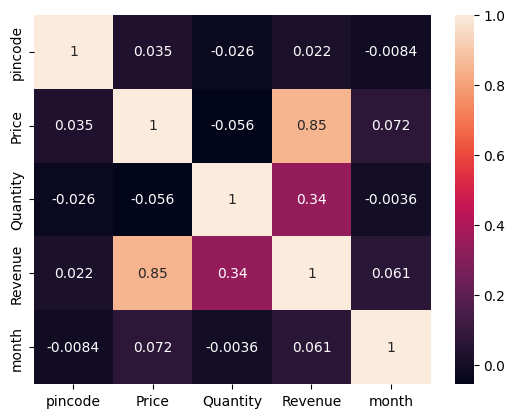

In [299]:
sns.heatmap(ndf.corr(numeric_only = True), annot = True)

In [300]:
for i in ndf.columns:
    print(f"{i}--------{ndf[i].nunique()}")
X = ndf[["pincode", "cleaned_city", "Product_name", "Price", "month", "category"]]
Y = ndf["Revenue"]

user_pseudo_id--------27898
pincode--------186
source_name--------82
source_medium--------27
source_origin--------41
cleaned_city--------233
Product_name--------180
Price--------102
Quantity--------14
Item_variant--------72
Revenue--------191
category--------9
month--------8


In [301]:
# One hot encoder
X = pd.get_dummies(X, columns = ["month","category"], drop_first= False)
#label encoder
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
clm = ["pincode", "cleaned_city","Product_name"]
for i in clm:
    X[i] = encoder.fit_transform(X[i])
X = X.astype(int)

In [302]:
# standard scalar
clm2 = ["pincode", "cleaned_city","Product_name", "Price"]
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X[clm2] = scalar.fit_transform(X[clm2]) 

In [315]:
#train test split and linear model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [339]:
model = LinearRegression()
model.fit(X_train, y_train)
R = Ridge(alpha = 1)
R.fit(X_train, y_train)

,alpha,1
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [340]:
y_pred = R.predict(X_test)

In [341]:
# r2_score
r2 = r2_score(y_test, y_pred)

#adjusted r2_score
n = X_test.shape[0]
p = X_test.shape[1]
adjusted_r2 = 1-((1-r2)*(n-1))/(n-p-1)

In [342]:
r2

0.4475832407431326